In [1]:
from Models import Get_data as Gd
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from Models.CAE import Encoder, Decoder, Autoencoder
from torchinfo import summary
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
from tqdm import tqdm
import random

In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(66)  # 你可以选择任意一个数字作为种子
# 启用浮点数异常检测
# torch.autograd.set_detect_anomaly(True)

In [3]:
# 检查是否有 GPU 可用
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

# 检查 GPU 的数量
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

# 获取每个 GPU 的名称
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

# 设置默认使用的 GPU 设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

GPU is available
Number of GPUs available: 1
GPU 0: NVIDIA GeForce RTX 4060 Laptop GPU
Using device: cuda:0


In [4]:
directory = '/home/wl4023/data/Sibo_22Mar2024'
folders = [os.path.join(directory, f, 'hessian_') for f in os.listdir(directory) if f.startswith('case_')]

# CAE

## Create Dataset for CAE

### Use all the case

In [5]:
dataset, length = Gd.get_all_nodes(folders[:-1])

train_np, val_np = train_test_split(dataset, test_size=0.2, shuffle=True)
train_np = np.expand_dims(train_np[:, :, 0], axis=2)
val_np = np.expand_dims(val_np[:, :, 0], axis=2)

In [6]:
train_tensor = torch.tensor(train_np, dtype=torch.float).permute(0, 2, 1)
train_tensor_set = Gd.MyDataset(train_tensor)

In [7]:
val_tensor = torch.tensor(val_np, dtype=torch.float).permute(0, 2, 1)
val_tensor_set = Gd.MyDataset(val_tensor)

In [8]:
train_loader = DataLoader(train_tensor_set, batch_size=5, shuffle=True)
val_loader = DataLoader(val_tensor_set, batch_size=5, shuffle=True)

In [9]:
preprocessor = Gd.Preprocessor()
preprocessor.fit(torch.concat((train_tensor, val_tensor), axis=0))
preprocessor.mean

tensor(6.9571)

### Test set

In [10]:
test_np, length = Gd.get_all_nodes(folders[-1:])
test_np = np.expand_dims(test_np[:, :, 0], axis=2)

In [11]:
print(folders[-1:])

['/home/wl4023/data/Sibo_22Mar2024/case_23/hessian_']


In [12]:
test_tensor = torch.tensor(test_np, dtype=torch.float).permute(0, 2, 1)
test_tensor_set = Gd.MyDataset(test_tensor)

## Model Info

In [13]:
latent_space = 25

In [14]:
# Create an instance of the model
encoder = Encoder(1, latent_space)
summary(encoder, input_size=(10, 1, 97149))

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [10, 25]                  --
├─Conv1d: 1-1                            [10, 4, 97149]            36
├─Dropout: 1-2                           [10, 4, 97149]            --
├─MaxPool1d: 1-3                         [10, 4, 19429]            --
├─Conv1d: 1-4                            [10, 4, 19429]            132
├─Dropout: 1-5                           [10, 4, 19429]            --
├─MaxPool1d: 1-6                         [10, 4, 3885]             --
├─Conv1d: 1-7                            [10, 1, 3885]             33
├─LeakyReLU: 1-8                         [10, 1, 3885]             --
├─Dropout: 1-9                           [10, 1, 3885]             --
├─MaxPool1d: 1-10                        [10, 1, 777]              --
├─AdaptiveAvgPool1d: 1-11                [10, 1, 1000]             --
├─Flatten: 1-12                          [10, 1000]                --
├─Linear: 1-13

In [15]:
decoder = Decoder(latent_space, 1)
summary(decoder, input_size=(10, latent_space))

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [10, 1, 97149]            --
├─Linear: 1-1                            [10, 512]                 13,312
├─Upsample: 1-2                          [10, 1, 1024]             --
├─Conv1d: 1-3                            [10, 1, 1018]             9
├─Linear: 1-4                            [10, 1, 97149]            98,994,831
├─Conv1d: 1-5                            [10, 1, 97149]            2
├─LeakyReLU: 1-6                         [10, 1, 97149]            --
Total params: 99,008,154
Trainable params: 99,008,154
Non-trainable params: 0
Total mult-adds (M): 992.12
Input size (MB): 0.00
Forward/backward pass size (MB): 15.67
Params size (MB): 396.03
Estimated Total Size (MB): 411.70

In [16]:
model = Autoencoder(1, latent_space)
summary(model, input_size=(10, 1, 97149))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [10, 1, 97149]            --
├─Encoder: 1-1                           [10, 25]                  --
│    └─Conv1d: 2-1                       [10, 4, 97149]            36
│    └─Dropout: 2-2                      [10, 4, 97149]            --
│    └─MaxPool1d: 2-3                    [10, 4, 19429]            --
│    └─Conv1d: 2-4                       [10, 4, 19429]            132
│    └─Dropout: 2-5                      [10, 4, 19429]            --
│    └─MaxPool1d: 2-6                    [10, 4, 3885]             --
│    └─Conv1d: 2-7                       [10, 1, 3885]             33
│    └─LeakyReLU: 2-8                    [10, 1, 3885]             --
│    └─Dropout: 2-9                      [10, 1, 3885]             --
│    └─MaxPool1d: 2-10                   [10, 1, 777]              --
│    └─AdaptiveAvgPool1d: 2-11           [10, 1, 1000]             --
│    └─Flatten

## Train CAE

In [17]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, y_true, y_pred):
        return torch.sqrt(self.mse(y_true, y_pred))
    
class NRMSE(nn.Module):
    def __init__(self, total_dataset):
        super(NRMSE, self).__init__()
        self.rmse = RMSELoss()
        self.factor = total_dataset.max()-total_dataset.min()

    def forward(self, y_true, y_pred):
        return self.rmse(y_true, y_pred)/self.factor

In [18]:
def train(model, train_loader, val_loader, criterion, optimizer, metric_train, metric_val, device,scheduler=None, epochs=30):
    train_NRMSELoss_list = []
    train_RMSELoss_list = []

    val_NRMSELoss_list = []
    val_RMSELoss_list = []
    
    min_loss = 10000

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        relative_train_loss = 0
        for x in tqdm(train_loader):
            input = preprocessor.transform(x).to(device)
            x = x.to(device)
            optimizer.zero_grad()
            predict= model(input)
            loss = criterion(input, predict)
            loss.backward()
            optimizer.step()
            
            train_loss += criterion(x, preprocessor.inverse_transform(predict)).item()
            relative_train_loss += metric_train(x, preprocessor.inverse_transform(predict)).item()

        if scheduler != None:
            scheduler.step()
        # print(train_loss, relative_train_loss, len(train_loader))
        train_loss /= len(train_loader)
        relative_train_loss /= len(train_loader)
        train_RMSELoss_list.append(train_loss)
        train_NRMSELoss_list.append(relative_train_loss)

        model.eval()
        relative_val_loss = 0
        with torch.no_grad():
            val_loss = 0
            relative_val_loss = 0
            for x in val_loader:
                input = preprocessor.transform(x).to(device)
                x = x.to(device)
                predict= model(input)

                val_loss += criterion(x, preprocessor.inverse_transform(predict)).item()
                relative_val_loss += metric_train(x, preprocessor.inverse_transform(predict)).item()

            val_loss /= len(val_loader)
            relative_val_loss /= len(val_loader)

            val_RMSELoss_list.append(val_loss)
            val_NRMSELoss_list.append(relative_val_loss)
        print(f'Epoch {epoch + 1}/{epochs}, train Loss: {train_loss}, NRMSE_train_loss: {relative_train_loss}, val Loss: {val_loss}, NRMSE_val_loss: {relative_val_loss}')
        
        if min_loss >= relative_val_loss:
            min_loss = relative_val_loss
            torch.save(model.state_dict(), 'CAE.pth')

    return train_RMSELoss_list, val_RMSELoss_list, train_NRMSELoss_list, val_NRMSELoss_list

In [19]:
model = Autoencoder(1, latent_space).to(device)
optimizer = optim.Adam(model.parameters())
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5)

## SCHEDULER

criterion = RMSELoss()
metric_train = NRMSE(train_tensor)
metric_val = NRMSE(val_tensor)

train_RMSELoss_list, val_RMSELoss_list, train_NRMSELoss_list, val_NRMSELoss_list = train(model,
                                                                                         train_loader,
                                                                                         val_loader,
                                                                                         criterion,
                                                                                         optimizer,
                                                                                         metric_train,
                                                                                         metric_val,
                                                                                         device,
                                                                                         scheduler = None,
                                                                                         epochs=50)

100%|██████████| 464/464 [00:25<00:00, 17.91it/s]


Epoch 1/50, train Loss: 5.780257033890691, NRMSE_train_loss: 0.11109310634241536, val Loss: 5.0761288034504854, NRMSE_val_loss: 0.09756017990153411


100%|██████████| 464/464 [00:24<00:00, 18.85it/s]


Epoch 2/50, train Loss: 2.6560033694680394, NRMSE_train_loss: 0.05104680696967989, val Loss: 3.4943612074029855, NRMSE_val_loss: 0.06715954681216128


100%|██████████| 464/464 [00:24<00:00, 18.80it/s]


Epoch 3/50, train Loss: 1.8825304690619995, NRMSE_train_loss: 0.03618111730561238, val Loss: 3.230129641705546, NRMSE_val_loss: 0.062081172965980806


100%|██████████| 464/464 [00:24<00:00, 18.89it/s]


Epoch 4/50, train Loss: 1.6312187773914173, NRMSE_train_loss: 0.031351055795375, val Loss: 2.5283114180482666, NRMSE_val_loss: 0.048592643619611346


100%|██████████| 464/464 [00:24<00:00, 18.89it/s]


Epoch 5/50, train Loss: 1.5568072527390102, NRMSE_train_loss: 0.029920910543296486, val Loss: 3.9500719360236465, NRMSE_val_loss: 0.07591803601525467


100%|██████████| 464/464 [00:24<00:00, 18.80it/s]


Epoch 6/50, train Loss: 1.3574392091611336, NRMSE_train_loss: 0.02608917521088031, val Loss: 3.3538816252659105, NRMSE_val_loss: 0.06445961270545578


100%|██████████| 464/464 [00:24<00:00, 18.69it/s]


Epoch 7/50, train Loss: 1.3543036133050919, NRMSE_train_loss: 0.026028910926784034, val Loss: 2.4082487544109084, NRMSE_val_loss: 0.046285110461557734


100%|██████████| 464/464 [00:24<00:00, 18.89it/s]


Epoch 8/50, train Loss: 1.2318235388475245, NRMSE_train_loss: 0.023674916658662903, val Loss: 2.973221914007746, NRMSE_val_loss: 0.05714355884441014


100%|██████████| 464/464 [00:24<00:00, 19.00it/s]


Epoch 9/50, train Loss: 1.1681560671021198, NRMSE_train_loss: 0.0224512656648836, val Loss: 3.251640206780927, NRMSE_val_loss: 0.06249459327102221


100%|██████████| 464/464 [00:24<00:00, 19.02it/s]


Epoch 10/50, train Loss: 1.157668078639384, NRMSE_train_loss: 0.022249692723813372, val Loss: 2.621389914689393, NRMSE_val_loss: 0.05038155677953157


100%|██████████| 464/464 [00:24<00:00, 18.96it/s]


Epoch 11/50, train Loss: 1.079613893774563, NRMSE_train_loss: 0.02074953769775236, val Loss: 3.384127407238401, NRMSE_val_loss: 0.06504091837218609


100%|██████████| 464/464 [00:24<00:00, 18.97it/s]


Epoch 12/50, train Loss: 1.0702813883023015, NRMSE_train_loss: 0.020570172512791408, val Loss: 3.038603247239672, NRMSE_val_loss: 0.05840014937687023


100%|██████████| 464/464 [00:24<00:00, 18.96it/s]


Epoch 13/50, train Loss: 1.0669643821130539, NRMSE_train_loss: 0.020506421623928153, val Loss: 3.4863837859753906, NRMSE_val_loss: 0.06700622508751936


100%|██████████| 464/464 [00:24<00:00, 19.01it/s]


Epoch 14/50, train Loss: 1.0246469196702899, NRMSE_train_loss: 0.01969310510020446, val Loss: 2.772025689482689, NRMSE_val_loss: 0.053276686945223604


100%|██████████| 464/464 [00:24<00:00, 18.92it/s]


Epoch 15/50, train Loss: 0.9351629904503452, NRMSE_train_loss: 0.01797327712571634, val Loss: 2.6642269039976187, NRMSE_val_loss: 0.051204858235372554


100%|██████████| 464/464 [00:24<00:00, 18.98it/s]


Epoch 16/50, train Loss: 1.0170550147264168, NRMSE_train_loss: 0.019547193215814707, val Loss: 2.4961340268110406, NRMSE_val_loss: 0.04797421300237806


100%|██████████| 464/464 [00:24<00:00, 19.12it/s]


Epoch 17/50, train Loss: 0.9891209965892906, NRMSE_train_loss: 0.019010318007625253, val Loss: 2.8556949105756035, NRMSE_val_loss: 0.05488475966106715


100%|██████████| 464/464 [00:24<00:00, 18.96it/s]


Epoch 18/50, train Loss: 1.01076350868519, NRMSE_train_loss: 0.019426274179593372, val Loss: 3.113016433756927, NRMSE_val_loss: 0.05983032634610246


100%|██████████| 464/464 [00:24<00:00, 18.92it/s]


Epoch 19/50, train Loss: 0.9277902544187061, NRMSE_train_loss: 0.017831577548098845, val Loss: 2.872085769628656, NRMSE_val_loss: 0.055199781946580984


100%|██████████| 464/464 [00:24<00:00, 18.94it/s]


Epoch 20/50, train Loss: 0.8994406065421885, NRMSE_train_loss: 0.017286714153356274, val Loss: 3.0413905505476326, NRMSE_val_loss: 0.05845371966153897


100%|██████████| 464/464 [00:24<00:00, 19.01it/s]


Epoch 21/50, train Loss: 0.9213817220438143, NRMSE_train_loss: 0.01770840930363067, val Loss: 2.9675406566981612, NRMSE_val_loss: 0.05703436862677336


100%|██████████| 464/464 [00:24<00:00, 18.92it/s]


Epoch 22/50, train Loss: 0.8778685685247183, NRMSE_train_loss: 0.01687211241444637, val Loss: 2.4489152678127946, NRMSE_val_loss: 0.04706669687132897


100%|██████████| 464/464 [00:24<00:00, 19.08it/s]


Epoch 23/50, train Loss: 0.8922945077948529, NRMSE_train_loss: 0.017149370345327167, val Loss: 2.9569814693311165, NRMSE_val_loss: 0.0568314274002252


100%|██████████| 464/464 [00:24<00:00, 18.88it/s]


Epoch 24/50, train Loss: 0.8565635617565492, NRMSE_train_loss: 0.01646264281790254, val Loss: 2.601140142514788, NRMSE_val_loss: 0.04999236804272594


100%|██████████| 464/464 [00:24<00:00, 18.98it/s]


Epoch 25/50, train Loss: 0.8429937844389471, NRMSE_train_loss: 0.01620183974616872, val Loss: 2.2594886093304076, NRMSE_val_loss: 0.04342602887030306


100%|██████████| 464/464 [00:24<00:00, 18.98it/s]


Epoch 26/50, train Loss: 0.8474073893037336, NRMSE_train_loss: 0.016286666637511348, val Loss: 2.518144630152604, NRMSE_val_loss: 0.048397243954241276


100%|██████████| 464/464 [00:24<00:00, 18.99it/s]


Epoch 27/50, train Loss: 0.8141550459609977, NRMSE_train_loss: 0.01564757634809337, val Loss: 2.4438675826993483, NRMSE_val_loss: 0.046969683054063856


100%|██████████| 464/464 [00:24<00:00, 18.97it/s]


Epoch 28/50, train Loss: 0.8646884198974947, NRMSE_train_loss: 0.016618797755278327, val Loss: 2.3096566488002908, NRMSE_val_loss: 0.04439022866527325


100%|██████████| 464/464 [00:24<00:00, 19.03it/s]


Epoch 29/50, train Loss: 0.8336653428730266, NRMSE_train_loss: 0.016022552673881554, val Loss: 2.807044278958748, NRMSE_val_loss: 0.05394972343768539


100%|██████████| 464/464 [00:24<00:00, 19.01it/s]


Epoch 30/50, train Loss: 0.8008419939413153, NRMSE_train_loss: 0.015391707394256032, val Loss: 2.9762956068433564, NRMSE_val_loss: 0.057202633518468715


100%|██████████| 464/464 [00:24<00:00, 18.87it/s]


Epoch 31/50, train Loss: 0.7579186709661936, NRMSE_train_loss: 0.014566746609614649, val Loss: 2.800688527781388, NRMSE_val_loss: 0.053827569611242104


100%|██████████| 464/464 [00:24<00:00, 19.09it/s]


Epoch 32/50, train Loss: 0.7738565941309107, NRMSE_train_loss: 0.01487306400667876, val Loss: 2.5998061011577476, NRMSE_val_loss: 0.049966728868733705


100%|██████████| 464/464 [00:24<00:00, 18.99it/s]


Epoch 33/50, train Loss: 0.7650312994574678, NRMSE_train_loss: 0.014703447081485828, val Loss: 3.255248444861379, NRMSE_val_loss: 0.06256394133228681


100%|██████████| 464/464 [00:24<00:00, 18.84it/s]


Epoch 34/50, train Loss: 0.7569150640789805, NRMSE_train_loss: 0.014547457858309921, val Loss: 2.640235806847441, NRMSE_val_loss: 0.050743763575908436


100%|██████████| 464/464 [00:24<00:00, 19.04it/s]


Epoch 35/50, train Loss: 0.7789038024714281, NRMSE_train_loss: 0.01497006837021688, val Loss: 2.483614000266996, NRMSE_val_loss: 0.04773358592827772


100%|██████████| 464/464 [00:24<00:00, 18.95it/s]


Epoch 36/50, train Loss: 0.7494591013367834, NRMSE_train_loss: 0.014404158751231393, val Loss: 2.466476897227353, NRMSE_val_loss: 0.04740422076128166


100%|██████████| 464/464 [00:24<00:00, 18.93it/s]


Epoch 37/50, train Loss: 0.7288849201567215, NRMSE_train_loss: 0.014008735177099127, val Loss: 2.4791996273501167, NRMSE_val_loss: 0.04764874411168797


100%|██████████| 464/464 [00:24<00:00, 19.03it/s]


Epoch 38/50, train Loss: 0.7808887632242565, NRMSE_train_loss: 0.015008218142862335, val Loss: 3.0553372476635308, NRMSE_val_loss: 0.058721766758967064


100%|██████████| 464/464 [00:24<00:00, 19.01it/s]


Epoch 39/50, train Loss: 0.7318828960174116, NRMSE_train_loss: 0.014066354520137197, val Loss: 2.4530193923876205, NRMSE_val_loss: 0.047145575477645314


100%|██████████| 464/464 [00:24<00:00, 18.96it/s]


Epoch 40/50, train Loss: 0.7271332117118712, NRMSE_train_loss: 0.013975068372834859, val Loss: 2.434401625703121, NRMSE_val_loss: 0.04678775313920502


100%|██████████| 464/464 [00:24<00:00, 18.94it/s]


Epoch 41/50, train Loss: 0.7519738577820104, NRMSE_train_loss: 0.014452490860251067, val Loss: 2.470861692366929, NRMSE_val_loss: 0.04748849389303861


100%|██████████| 464/464 [00:24<00:00, 18.94it/s]


Epoch 42/50, train Loss: 0.6734518316927655, NRMSE_train_loss: 0.012943344135519824, val Loss: 2.7375753994645744, NRMSE_val_loss: 0.052614572923630476


100%|██████████| 464/464 [00:24<00:00, 18.92it/s]


Epoch 43/50, train Loss: 0.7243649619792042, NRMSE_train_loss: 0.013921864263528701, val Loss: 2.2657533221203705, NRMSE_val_loss: 0.04354643286205828


100%|██████████| 464/464 [00:24<00:00, 19.01it/s]


Epoch 44/50, train Loss: 0.7226547710597515, NRMSE_train_loss: 0.01388899538091962, val Loss: 2.212614413993112, NRMSE_val_loss: 0.0425251345953037


100%|██████████| 464/464 [00:24<00:00, 18.98it/s]


Epoch 45/50, train Loss: 0.6574448568039927, NRMSE_train_loss: 0.012635699613822689, val Loss: 2.691686202739847, NRMSE_val_loss: 0.05173260986740733


100%|██████████| 464/464 [00:24<00:00, 18.92it/s]


Epoch 46/50, train Loss: 0.6913942543083224, NRMSE_train_loss: 0.013288186826935873, val Loss: 2.5500064456257325, NRMSE_val_loss: 0.04900960917263452


100%|██████████| 464/464 [00:24<00:00, 19.07it/s]


Epoch 47/50, train Loss: 0.6788230246767916, NRMSE_train_loss: 0.013046575256559098, val Loss: 2.4421904079359154, NRMSE_val_loss: 0.04693744880356023


100%|██████████| 464/464 [00:24<00:00, 19.02it/s]


Epoch 48/50, train Loss: 0.7151305918935044, NRMSE_train_loss: 0.013744385135239633, val Loss: 2.409458040677268, NRMSE_val_loss: 0.04630835218644091


100%|██████████| 464/464 [00:24<00:00, 18.88it/s]


Epoch 49/50, train Loss: 0.708798987662484, NRMSE_train_loss: 0.01362269545668447, val Loss: 2.7908779238832406, NRMSE_val_loss: 0.053639015889373316


100%|██████████| 464/464 [00:24<00:00, 18.97it/s]


Epoch 50/50, train Loss: 0.6794061036459331, NRMSE_train_loss: 0.013057781716583875, val Loss: 2.370364409068535, NRMSE_val_loss: 0.045556995825007045


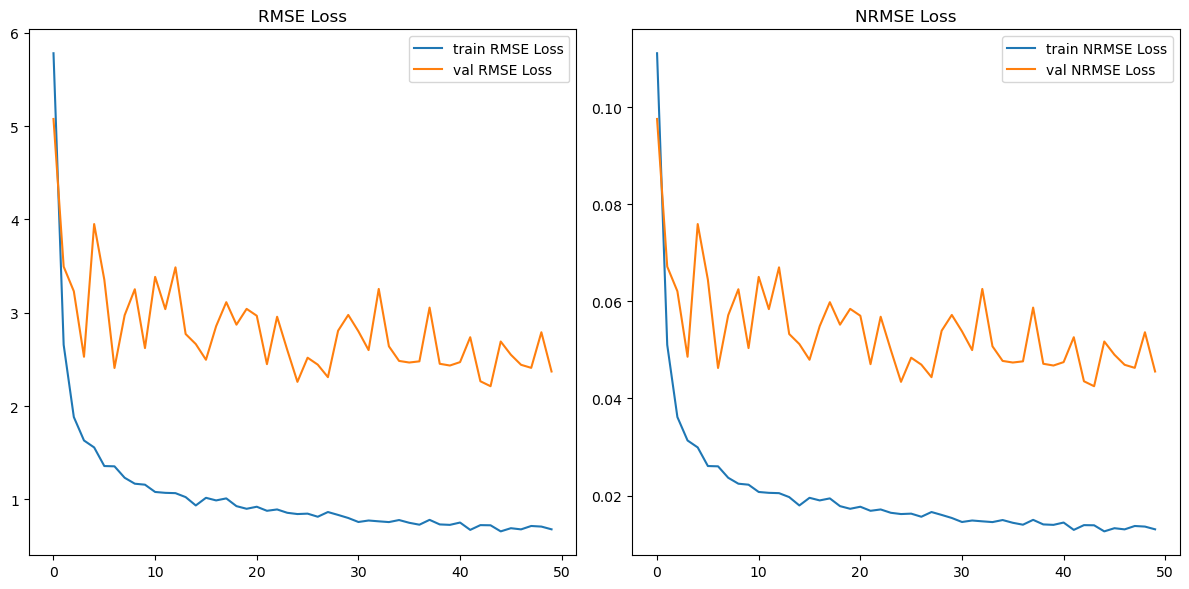

In [20]:
fig1, axs = plt.subplots(1, 2, figsize=(12, 6))
train_RMSELoss_list, val_RMSELoss_list, train_NRMSELoss_list, val_NRMSELoss_list
axs[0].plot(train_RMSELoss_list, label='train RMSE Loss')
axs[0].plot(val_RMSELoss_list, label='val RMSE Loss')
axs[0].set_title("RMSE Loss")
axs[0].legend()

axs[1].plot(train_NRMSELoss_list, label='train NRMSE Loss')
axs[1].plot(val_NRMSELoss_list, label='val NRMSE Loss')
axs[1].set_title("NRMSE Loss")
axs[1].legend()

plt.tight_layout()  # 调整布局以防止重叠
# plt.savefig('CAE_train_loss.png')  # 你可以更改文件名或格式
plt.show()


## Result

In [21]:
def draw_pic(x, y, coords):
    fig1, axs = plt.subplots(1, 5, figsize=(30, 6))
    for i in range(len(axs)):
        axs[i].scatter(coords[:,0],coords[:,1],s = 5, c=x[i, 0, :], cmap='bwr')
        axs[i].set_title(f'Input {i+1}')
    plt.show()
    plt.close()

    fig2, axs = plt.subplots(1, 5, figsize=(30, 6))
    for i in range(len(axs)):
        axs[i].scatter(coords[:,0],coords[:,1],s = 5, c=y[i, 0, :], cmap='bwr')
        axs[i].set_title(f'Predict {i+1}')
    plt.show()
    plt.close()


In [22]:
xyfile = "/home/wl4023/data/Sibo_22Mar2024/case_0/hessian_/xy_coords.npy"
xycoords_check = np.load(xyfile)

In [23]:
model = Autoencoder(1, latent_space)
# 加载保存的状态字典
state_dict = torch.load('CAE.pth')
model.load_state_dict(state_dict)
model.to(device)

Autoencoder(
  (encoder): Encoder(
    (conv1): Conv1d(1, 4, kernel_size=(8,), stride=(1,), padding=same, dilation=(2,))
    (dropout1): Dropout(p=0.1, inplace=False)
    (pool1): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv1d(4, 4, kernel_size=(8,), stride=(1,), padding=same, dilation=(2,))
    (dropout2): Dropout(p=0.1, inplace=False)
    (pool2): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv1d(4, 1, kernel_size=(8,), stride=(1,), padding=same, dilation=(2,))
    (leaky_relu): LeakyReLU(negative_slope=0.3)
    (dropout3): Dropout(p=0.1, inplace=False)
    (pool3): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (avg_pool): AdaptiveAvgPool1d(output_size=1000)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (dense): Linear(in_features=1000, out_features=25, bias=True)
  )
  (decoder): Decoder(
    (dense1): Linear(in_features=25, out_features=512, bias=True)

In [24]:
test_tensor = test_tensor.to(device)
input = preprocessor.transform(test_tensor)
y = model(input)
y = preprocessor.inverse_transform(y)
criterion = RMSELoss()
metric = NRMSE(test_tensor)

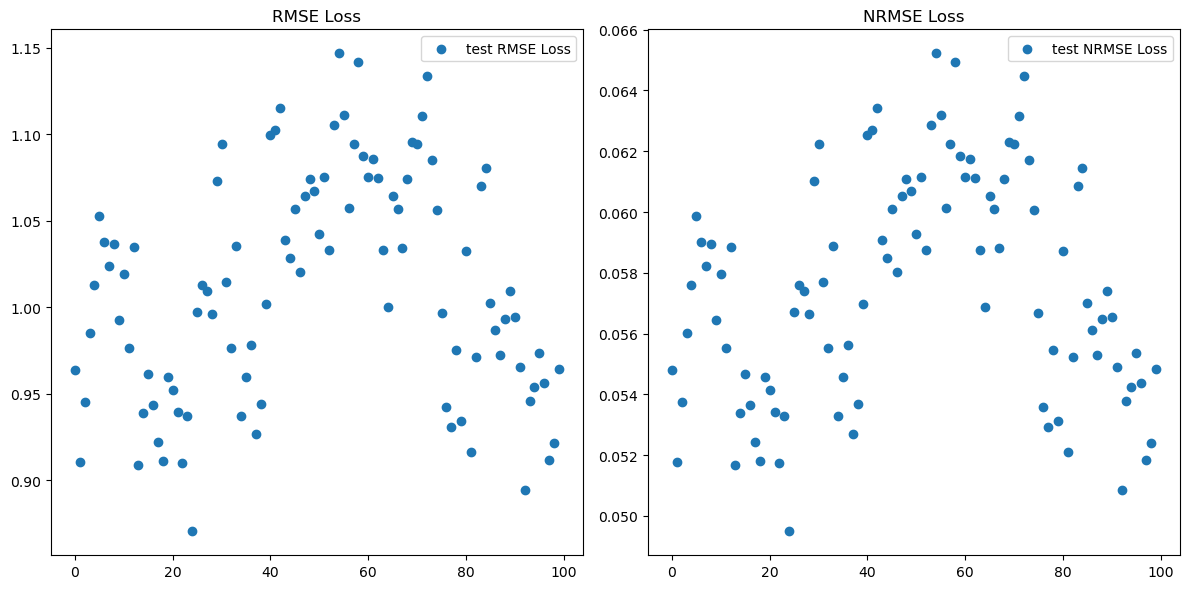

In [25]:
test_rmse=[]
test_nrmse=[]
for i in range(len(test_tensor)):
    nrmse = metric(test_tensor[i], y[i])
    rmse = criterion(test_tensor[i], y[i])

    test_rmse.append(rmse.cpu().detach().numpy())
    test_nrmse.append(nrmse.cpu().detach().numpy())


x = np.arange(0, 100)
test_rmse = np.array(test_rmse)
test_nrmse = np.array(test_nrmse)

# 保存数组到 .npy 文件
np.save('test_rmse.npy', test_rmse)
np.save('test_nrmse.npy', test_nrmse)

fig1, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].scatter(x, test_rmse, label='test RMSE Loss')
axs[0].set_title("RMSE Loss")
axs[0].legend()

axs[1].scatter(x, test_nrmse, label='test NRMSE Loss')
axs[1].set_title("NRMSE Loss")
axs[1].legend()


plt.tight_layout()  # 调整布局以防止重叠

# plt.savefig('CAE_test_loss.png')  # 你可以更改文件名或格式

plt.show()

In [26]:
y_np = y[:5].cpu().detach().numpy()
x_np = test_tensor[:5].cpu().detach().numpy()
rmse = criterion(test_tensor, y).item()
nrmse = metric(test_tensor, y).item()
print(f"Ave RMSE test loss: {rmse}")
print(f"Ave NRMSE test loss: {nrmse}")

Ave RMSE test loss: 1.0124112367630005
Ave NRMSE test loss: 0.05757321044802666


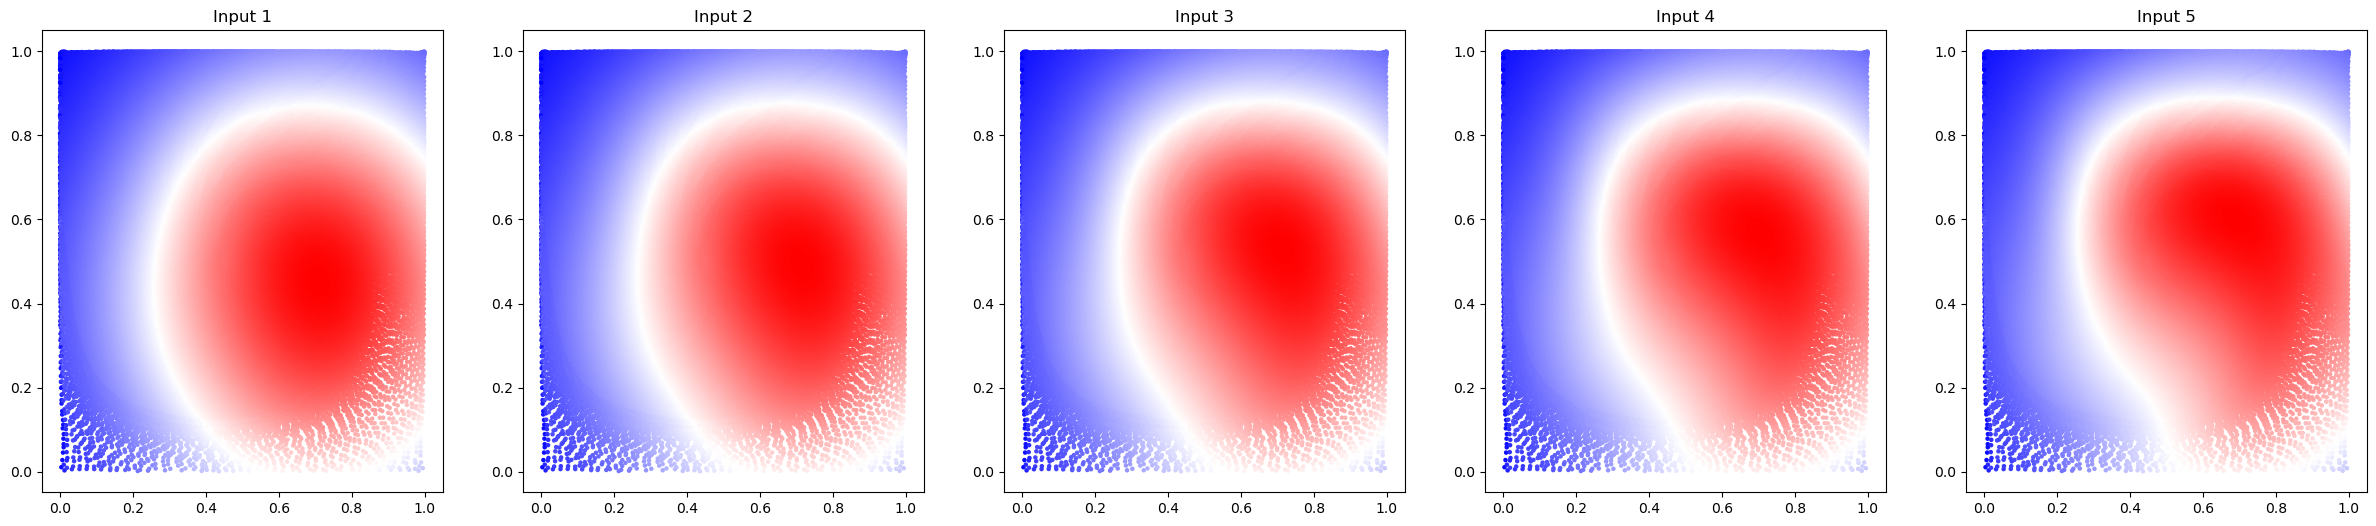

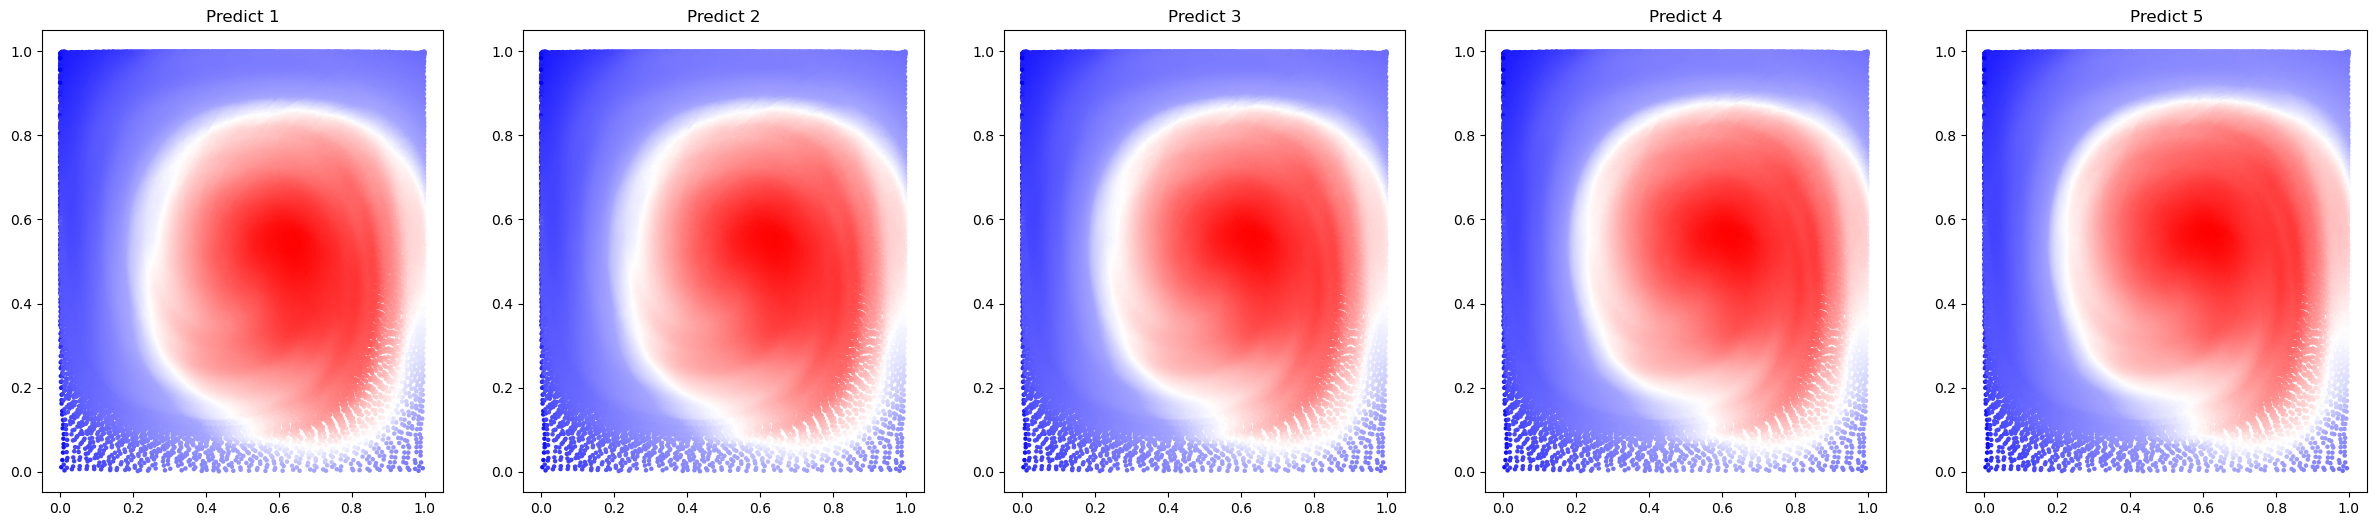

In [27]:
draw_pic(x_np, y_np, xycoords_check)